In [3]:
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt

## Put books & summaries in dataframe

In [4]:
# Function to read text from a file
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

# Path to the folders containing book and summary text files
books_folder = 'D:\Gethub\SummaryFlow\All_novels'
summaries_folder = 'D:\Gethub\SummaryFlow\All_summaries'

# List all files in each folder
books_files = os.listdir(books_folder)
summaries_files = os.listdir(summaries_folder)

# Initialize lists to store book titles, book text, and summary text
book_titles = []
book_texts = []
summary_texts = []

# Iterate over each book file
for book_file in books_files:
    # Check if there exists a corresponding summary file
    summary_file = os.path.join(summaries_folder, book_file)
    if os.path.isfile(summary_file):
        # Read book text
        book_text = read_text_file(os.path.join(books_folder, book_file))
        # Read summary text
        summary_text = read_text_file(summary_file)
        # Append data to lists
        book_titles.append(os.path.splitext(book_file)[0])
        book_texts.append(book_text)
        summary_texts.append(summary_text)

# Create a DataFrame
data = {
    'Title': book_titles,
    'Book': book_texts,
    'Summary': summary_texts
}
df = pd.DataFrame(data)

# Display the DataFrame
print(df.head())

# Optionally, you can save the DataFrame to a Excel file
#df.to_excel('books_dataset.xlsx', index=False)


                          Title  \
0      A Canticle for Leibowitz   
1             A Christmas Carol   
2            A Clockwork Orange   
3  A Descent into the Maelstrom   
4            A Farewell to Arms   

                                                Book  \
0  A CANTICLE FOR LEIBOWITZ  \n\nWalter M. Miller...   
1  IN PROSE \n\nBEING \n\n                       ...   
2  Anthony Burgess\n\nThe Restored Edition\n\nEdi...   
3  that the weightier portion of his body hung \n...   
4  A FAREWELL\n\nVtf 'it\n\nERNEST HEXi\n\n*~~-\n...   

                                             Summary  
0   A Canticle for Leibowitz opens 600 years afte...  
1   Dickens divides the book into five chapters, ...  
2   Alex, a teenager living in near-future Englan...  
3   Inspired by the Moskstraumen, it is couched a...  
4   The novel is divided into five books. In the ...  


In [5]:
len(df)

288

In [6]:
df.sample(5)

,Title,Book,Summary
79,Heart of Darkness,PENGUIN CLASSICS \n DELUXE EDITION\n\nHEART OF...,'Heart of Darkness' opens in first person nar...
110,Look to Windward,"Look To Windward (v1.1) \n\nIain M. Banks, 200...","Despite the passage of time, Major Quilan sti..."
261,The Sweet Hereafter,The Sweet \nHereafter\n\nA Novel by \n\nRussel...,The Sweet Hereafter is a multiple first perso...
40,Damage,OceanofPDF.com\n\nDamage\n\nJosephine Hart\n\n...,The first person narrator of the novel is an ...
197,The Cider House Rules,The Cider House Rules\n\nJohn Irving\n\nDedica...,Homer Wells grows up in an orphanage where he...


In [18]:
df.Book[0]

'A CANTICLE FOR LEIBOWITZ  \n\nWalter M. Miller, Jr.  \n\nCONTENTS  \n\nAcknowledgement  \n\nPart I Fiat Homo  \n\nChapter One  \n\nChapter Two  \n\nChapter Three  \n\nChapter Four  \n\nChapter Five  \n\nChapter Six  \n\nChapter Seven  \n\nChapter Eight  \n\nChapter Nine  \n\nChapter Ten  \n\nChapter Eleven  \n\nPart II Fiat Lux  \n\nChapter Twelve  \n\nChapter Thirteen  \n\nChapter Fourteen  \n\nChapter Fifteen  \n\nChapter Sixteen  \n\nChapter Seventeen  \n\nChapter Eighteen  \n\nChapter Nineteen  \n\nChapter Twenty  \n\nChapter Twenty-one  \n\nChapter Twenty-two  \n\nChapter Twenty-three  \n\nPart III Fiat Voluntas Tua  \n\nChapter Twenty-four  \n\nChapter Twenty-five  \n\nChapter Twenty-six  \n\nChapter Twenty-seven  \n\nChapter Twenty-eight  \n\nChapter Twenty-nine  \n\nChapter Thirty  \n\nACKNOWLEDGMENT  \n\nTo all those whose assistance, in various ways, contributed \n\nto making this book possible, the author expresses his \n\nappreciation and gratitude, especially and explicit

## Split the book into sentences

In [19]:
# Split the book into sentences and store them in a list
import nltk
from nltk.tokenize import sent_tokenize

books = []
for i in range(len(df)):
    book_sentences = sent_tokenize(df.Book[i])
    books.append(book_sentences)

In [25]:
books[0][12]

'The pilgrim was a spindly old fellow with a staff, a basket \n\nhat, a brushy beard, and a waterskin slung over one \n\nshoulder.'

In [26]:
# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
for i in range(len(books)):
    books[i] = ["[CLS] " + sentence + " [SEP]" for sentence in books[i]]
labels = df.Summary.values

In [29]:
books[200][12]

'[CLS] The \n\nmeeting house was nearby, and from this point outward - toward the bay or inland - \nthere were a few small-windowed, dark houses snuggling against the raw Massa-\nchusetts winter. [SEP]'

## Tokenization

In [30]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_books = []
for i in range(len(books)):
    tokenized_texts = [tokenizer.tokenize(sentence) for sentence in books[i]]
    tokenized_books.append(tokenized_texts)
print ("Tokenize the first sentence:")
print (tokenized_books[0])

Tokenize the first sentence:
[['[CLS]', 'a', 'can', '##tic', '##le', 'for', 'lei', '##bow', '##itz', 'walter', 'm', '.', 'miller', ',', 'jr', '.', '[SEP]'], ['[CLS]', 'contents', 'acknowledge', '##ment', 'part', 'i', 'fiat', 'homo', 'chapter', 'one', 'chapter', 'two', 'chapter', 'three', 'chapter', 'four', 'chapter', 'five', 'chapter', 'six', 'chapter', 'seven', 'chapter', 'eight', 'chapter', 'nine', 'chapter', 'ten', 'chapter', 'eleven', 'part', 'ii', 'fiat', 'lux', 'chapter', 'twelve', 'chapter', 'thirteen', 'chapter', 'fourteen', 'chapter', 'fifteen', 'chapter', 'sixteen', 'chapter', 'seventeen', 'chapter', 'eighteen', 'chapter', 'nineteen', 'chapter', 'twenty', 'chapter', 'twenty', '-', 'one', 'chapter', 'twenty', '-', 'two', 'chapter', 'twenty', '-', 'three', 'part', 'iii', 'fiat', 'vol', '##unt', '##as', 'tu', '##a', 'chapter', 'twenty', '-', 'four', 'chapter', 'twenty', '-', 'five', 'chapter', 'twenty', '-', 'six', 'chapter', 'twenty', '-', 'seven', 'chapter', 'twenty', '-', 'ei

In [36]:
tokenized_books[0][1504]

['[CLS]',
 'je',
 '##ris',
 'was',
 'becoming',
 'pre',
 '##ten',
 '##tious',
 'in',
 'his',
 'sarcasm',
 ',',
 'francis',
 'observe',
 'this',
 'column',
 'of',
 'figures',
 ',',
 'and',
 'its',
 'heading',
 ':',
 "'",
 'electronics',
 'parts',
 'numbers',
 '.',
 "'",
 '[SEP]']

## Word encoding

In [38]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
books_ids = []
for i in range(len(tokenized_books)):
    input_ids = [tokenizer.convert_tokens_to_ids(word) for word in tokenized_books[i]]
    books_ids.append(input_ids)

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (973 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (1147 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (1521 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (1009 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (1060 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence leng

In [40]:
# Pad our input tokens
MAX_LEN = 512
for i in range(len(books_ids)):
    books_ids[i] = pad_sequences(books_ids[i], maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

## Split data to train, test & validation

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

## Convert data into tensors

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

## Create an iterator with torch DataLoader

In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## Load the model

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

## Set model parameters

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
]

# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters, lr=2e-5, warmup=.1)

## Train the model

In [ ]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
  # Validation
  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.5341928047263276


Epoch:  25%|██▌       | 1/4 [06:40<20:01, 400.47s/it]

Validation Accuracy: 0.7820216049382716
Train loss: 0.28573063393104126


Epoch:  50%|█████     | 2/4 [13:20<13:20, 400.19s/it]

Validation Accuracy: 0.820216049382716
Train loss: 0.14156816012314927


Epoch:  75%|███████▌  | 3/4 [20:00<06:40, 400.07s/it]

Validation Accuracy: 0.8248456790123456
Train loss: 0.0655116576486928


Epoch: 100%|██████████| 4/4 [26:40<00:00, 400.07s/it]

Validation Accuracy: 0.8233024691358025


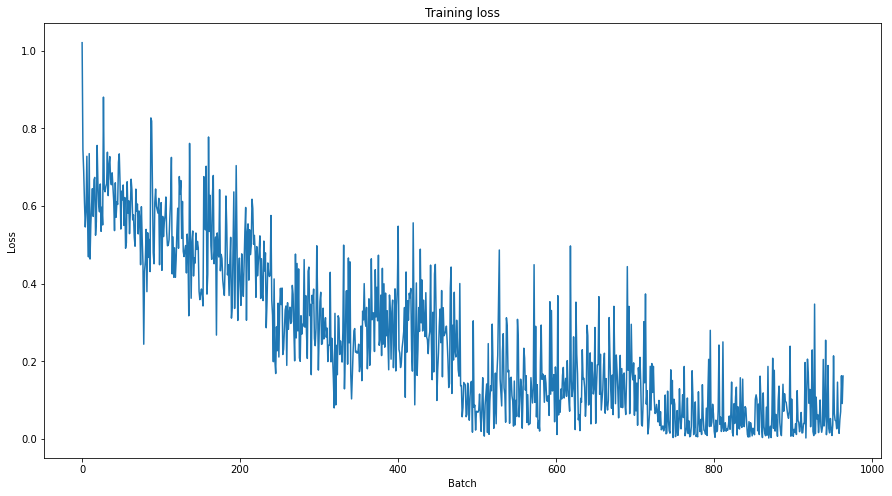

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## Testing the model